# Neuroimaging Connectomics #4: M/EEG Connectivity


In this final neuroimaging connectomics tutorial, we will look fairly briefly at fast-timescale noninvasive neural activity and functional connectivity measurements with M/EEG.

Just as our tractography tutorial was closely based on previous tutorials from the dipy library, this one is closely based on a [tutorial from the MNE library](https://mne.tools/dev/auto_examples/connectivity/mne_inverse_label_connectivity.html), with our own special additions and embellishments. 

[MNE](https://mne.tools/dev/index.html) is a very powerful open-soure software library from a very active and friendly group of developers based in Paris. In our opinion it is the best, and in fact really the only, way to analyze EEG and MEG data - including simulated data from whole-brain models.

We will do the following: 


- From raw data, run a complete M+EEG source reconstruction, obtaining source time series estimates from our familiar freesurfer aparc parcels 
- Take a quick peek at the M/EEG power spectrum along the way
- Compute a series of alternative functional connectivity metrics and visualize the results
- Revisit along the way some some familiar characters like brain surfaces

## Setup

In [1]:
# If running in google colab: uncomment these lines to install some packages:

#!pip install mne 

Importage: 

In [2]:
# Generic Imports
import os,sys,glob,numpy as np,pandas as pd

# Viz stuff
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# MNE stuff
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

In [3]:
# An improved aparc label ordering that we will use
orig_to_abey_idx = np.array([46, 32, 50, 58, 16,  6, 22, 42, 26, 20, 12, 34, 16,  8, 64, 18, 60,
       66, 30,  0, 62, 44, 48,  4, 56,  2, 54, 36, 40, 38, 24, 28, 52, 10,
       47, 33, 51, 59, 15,  7, 23, 43, 27, 21, 13, 35, 17,  9, 65, 19, 61,
       67, 31,  1, 63, 45, 49,  5, 57,  3, 55, 37, 41, 39, 25, 29, 53, 11])
abey_to_orig_idx = np.zeros_like(orig_to_abey_idx)
for o_it,o in enumerate(orig_to_abey_idx): abey_to_orig_idx[o] = o_it

reidx = orig_to_abey_idx

## Grab and load the data

In [4]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Load data
inverse_operator = read_inverse_operator(fname_inv)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel
raw.info['bads'] += ['MEG 2443']

# Pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')


Using default location ~/mne_data for sample...



Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Reading inverse operator decomposition from /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find th

In [127]:
raw

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>

Take a look at the power spectrum

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


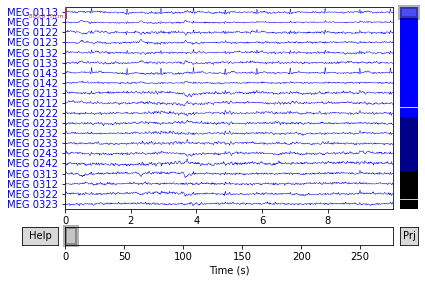

In [121]:
disp = raw.plot();

Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


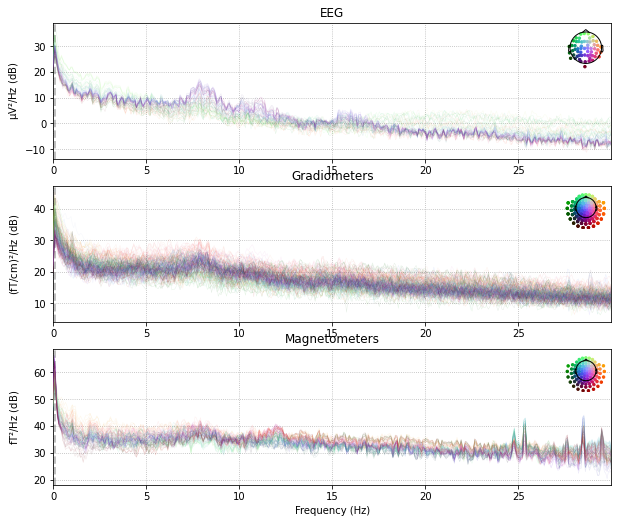

<Figure size 432x288 with 0 Axes>

In [10]:
disp = raw.plot_psd(fmin=0,fmax=30,xscale='linear',line_alpha=0.1,n_overlap=20);
plt.tight_layout()

Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


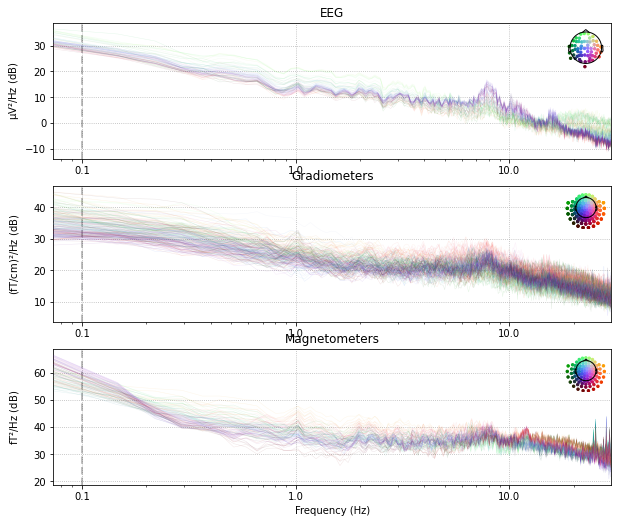

<Figure size 432x288 with 0 Axes>

In [11]:
disp = raw.plot_psd(fmin=0,fmax=30,xscale='log',line_alpha=0.1);
plt.tight_layout()

## Define epochs

In [7]:
# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                                                    eog=150e-6))

Not setting metadata
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated


## Grab the parcellation

In [8]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('sample', parc='aparc',
                                    subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

Reading labels from parcellation...
   read 34 labels from /root/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /root/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot


## Compute inverse solution

In [9]:
# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)


# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode='mean_flip', return_generator=False)#True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
Processing epoch : 2 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
Processing epoch : 3 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
Processing epoch : 4 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
Processing epoch : 5 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
Processing epoch : 6 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_fli

Take a look at the source time series

## Compute connectivity

First - just the Pearson corrs

In [76]:
mat = np.mean([np.corrcoef(l) for l in label_ts],axis=0)

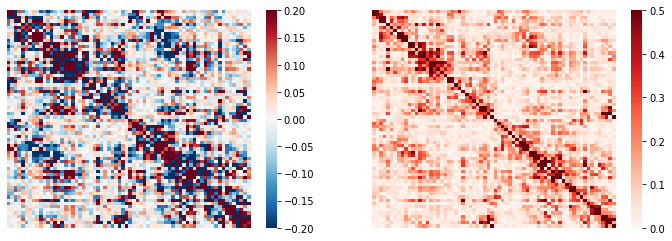

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

sns.heatmap(mat[reidx,:][:,reidx],cmap='RdBu_r',vmin=-0.2,vmax=0.2,ax=ax[0],
            xticklabels='',yticklabels='');

sns.heatmap(np.abs(mat[reidx,:][:,reidx]),cmap='Reds',vmin=0,vmax=0.5,ax=ax[1],
            xticklabels='',yticklabels='');

Next - phase-based connectivity estimates

In [17]:
fmin = 8.
fmax = 13.
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..0.699s for estimation (106 points)
    frequencies: 8.5Hz..12.7Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI, Debiased WPLI Square, ciPLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch

Look at matrix plots of the connectivity

In [83]:
con_res.keys()

dict_keys(['pli', 'wpli2_debiased', 'ciplv'])

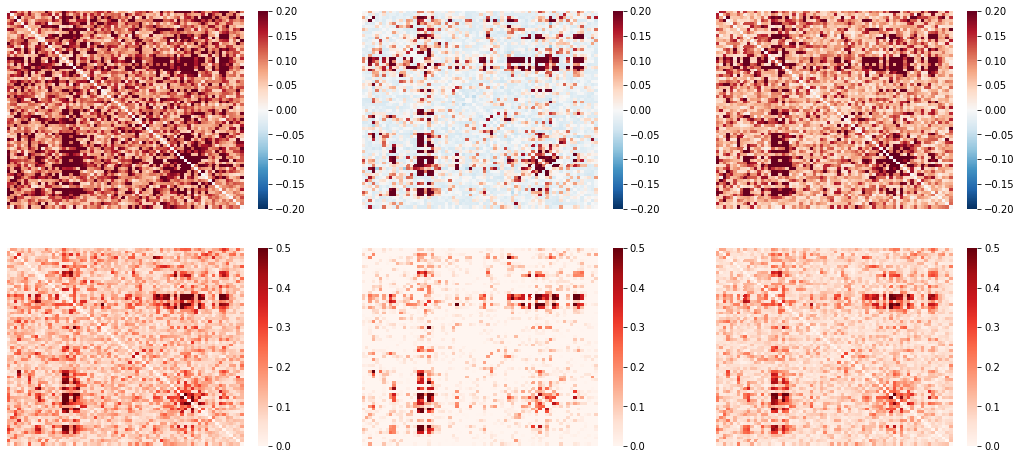

In [86]:
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(18,8))


for contype_it,contype in enumerate(['pli', 'wpli2_debiased', 'ciplv']):
  mat = con_res[contype].copy()
  mat = (mat + mat.T)[reidx,:][:,reidx]

  sns.heatmap(mat,cmap='RdBu_r',vmin=-0.2,vmax=0.2,ax=ax[0][contype_it],
            xticklabels='',yticklabels='');

  sns.heatmap(mat,cmap='Reds',vmin=0,vmax=0.5,ax=ax[1][contype_it],
            xticklabels='',yticklabels='');

Circle-based connectivity visualization

In [117]:
con_res.keys()

dict_keys(['pli', 'wpli2_debiased', 'ciplv'])

In [119]:
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

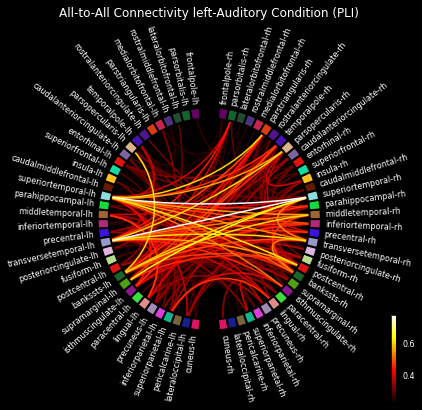

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7fc98702e450>)

In [114]:
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')

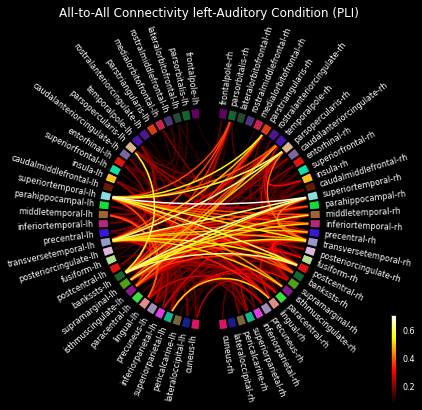

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7fc98755db90>)

In [115]:
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['wpli2_debiased'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')

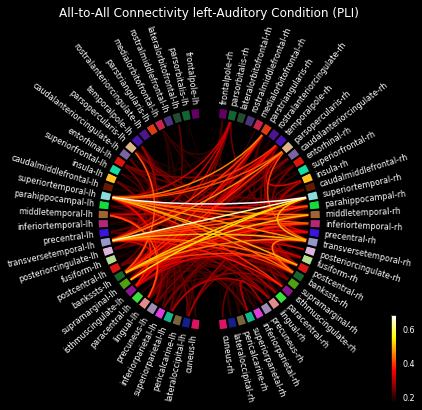

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7fc985e508d0>)

In [118]:
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['ciplv'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')